# Part 4 -- Model v3 Training -- Base LLM model on the "Industry", "Meta-description" and "Homepage text" features

In [1]:
import evaluate
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import torch

from datasets import Dataset, DatasetDict
from sklearn.preprocessing import LabelEncoder
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, EarlyStoppingCallback, Trainer, TrainingArguments

/home/bishop/miniconda3/envs/dialectica/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load exported Full dataset to a Pandas DataFrame

In [3]:
df = pd.read_csv(os.path.join('data', 'dataset.csv'))

In [4]:
# Percentage of missing values
df.isna().mean()

id                  0.000000
industry            0.000000
homepage_text       0.986547
meta_description    0.987719
category            0.986424
dtype: float64

In [5]:
# Data features types
df.dtypes

id                   int64
industry            object
homepage_text       object
meta_description    object
category            object
dtype: object

In [6]:
model_name = 'ft3'
text_cols = ['industry', 'meta_description', 'homepage_text']
label_col = 'category'

In [7]:
df = df.dropna(subset=text_cols+[label_col]).reset_index(drop=True)

## Data transformation based on Label (category) and Text (input) feature(s)

In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Removing HTML tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Remove redundant whitespaces at the beginning and at the end
    sentence = sentence.strip()

    return sentence


for col in text_cols:
    texts = []
    for sen in list(df[col].astype(str)):
        texts.append(preprocess_text(sen))

    df.loc[:, col] = pd.Series((sen for sen in texts))

In [9]:
df['text'] = df[text_cols].apply(lambda x: ' [SEP] '.join(x.values.astype(str)), axis=1)
df = df.dropna(subset=['text']).reset_index(drop=True)

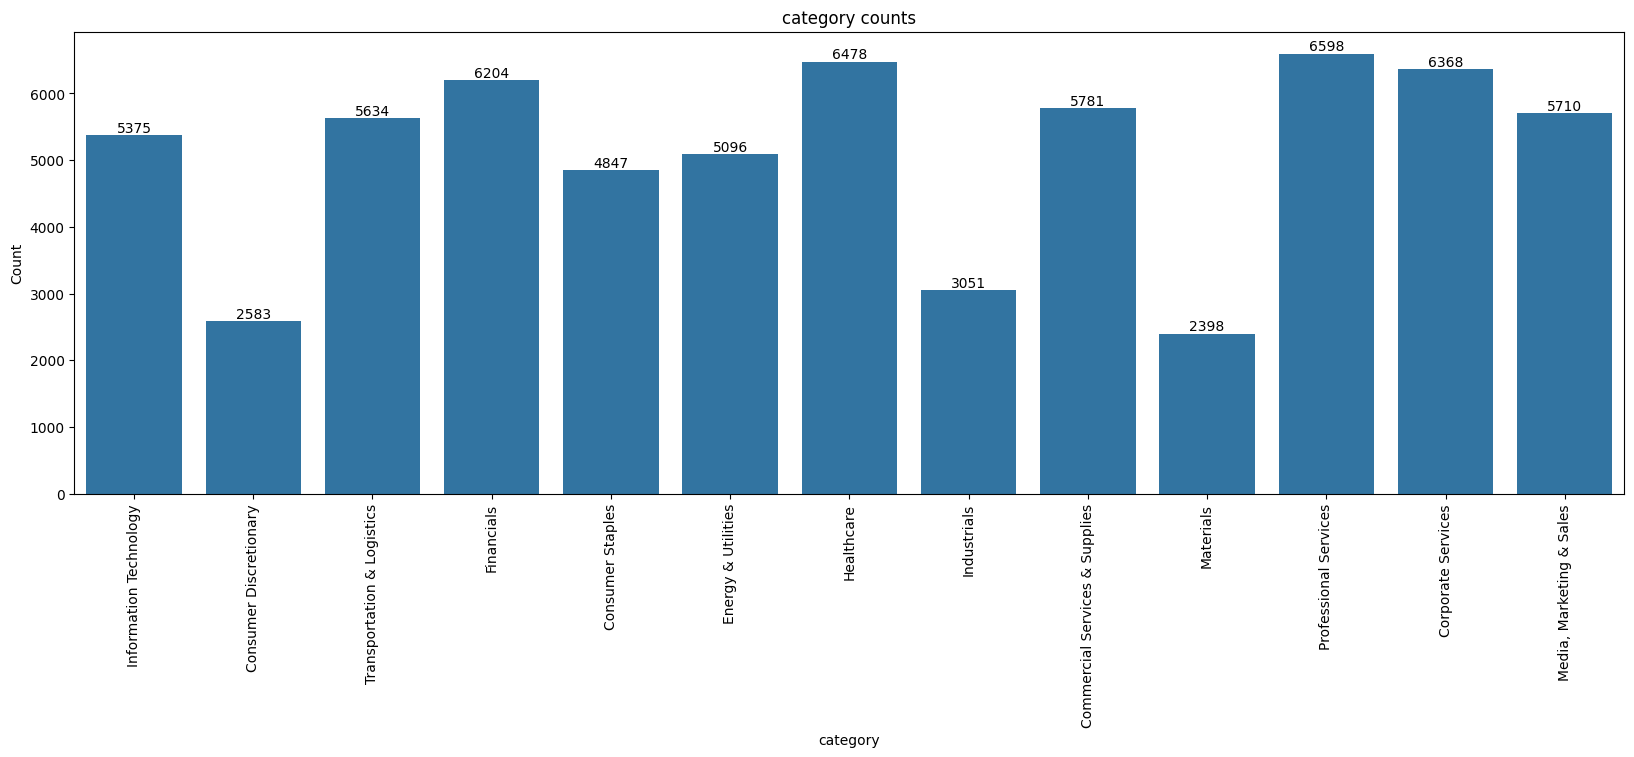

In [10]:
plt.figure(figsize=(20, 6))

ax = sns.countplot(data=df, x=label_col)

plt.title(f'{label_col} counts')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')

plt.ylabel('Count')
plt.xlabel(label_col)
plt.xticks(rotation=90)
plt.show()

In [11]:
le = LabelEncoder()
le.fit(df[label_col])

le_keys = le.classes_
le_values = le.transform(le_keys)
le_params = dict(zip(le_keys, le_values))

with open(os.path.join('data', 'labels.json'), 'w') as fp:
    json.dump(le_params, fp, default=str)

In [12]:
df['label'] = le.transform(df[label_col])

In [13]:
num_labels = df['label'].nunique()
label_min_count = df.groupby('label').size().min()

print('Lowest label samples count:', label_min_count)

Lowest label samples count: 2398


In [14]:
print('Percentage of missing values')
df.isna().mean()

Percentage of missing values


id                  0.0
industry            0.0
homepage_text       0.0
meta_description    0.0
category            0.0
text                0.0
label               0.0
dtype: float64

## Split data into class-balanced Training and Test sets

In [15]:
eval_dataset_frac = 0.15
train_dataset_frac = 1 - eval_dataset_frac

In [16]:
train_dataset_counts_per_label = int(math.floor(label_min_count * (1 - eval_dataset_frac)))
eval_dataset_counts_per_label = label_min_count - train_dataset_counts_per_label

print('Training samples count per label:', train_dataset_counts_per_label)
print('Training samples count per label:', eval_dataset_counts_per_label)

Training samples count per label: 2038
Training samples count per label: 360


In [17]:
dfgb = df.groupby(by=[label_col])
df_train = dfgb.apply(lambda group: group.sample(n=train_dataset_counts_per_label, random_state=13), include_groups=False)
df_train = df_train.reset_index(level=0, drop=False)

df_train.drop(columns=['text', 'label']).to_csv(os.path.join('data', 'train.csv'), index=False)
df_train.count()

category            26494
id                  26494
industry            26494
homepage_text       26494
meta_description    26494
text                26494
label               26494
dtype: int64

In [18]:
dfgb = df[~df['id'].isin(df_train['id'])].groupby(by=[label_col])
df_eval = dfgb.apply(lambda group: group.sample(n=eval_dataset_counts_per_label, random_state=13), include_groups=False)
df_eval = df_eval.reset_index(level=0, drop=False)

df_eval.drop(columns=['text', 'label']).to_csv(os.path.join('data', 'eval.csv'), index=False)
df_eval.count()

category            4680
id                  4680
industry            4680
homepage_text       4680
meta_description    4680
text                4680
label               4680
dtype: int64

## Tokenize text data

In [19]:
# Tokenize text features
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [20]:
ds_train = Dataset.from_pandas(df_train[['label', 'text']])
ds_eval = Dataset.from_pandas(df_eval[['label', 'text']])

ds = DatasetDict({
    'train': ds_train, 
    'eval': ds_eval
})

In [21]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

tokenized_datasets = ds.map(tokenize_function)

Map: 100%|████████████████████████████████████████████████████████| 4680/4680 [00:09<00:00, 481.88 examples/s]


## Configure model training parameters

In [22]:
configuration = AutoConfig.from_pretrained('bert-base-uncased', num_labels=num_labels)
configuration.hidden_dropout_prob = 0.2
configuration.attention_probs_dropout_prob = 0.2

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', config=configuration)

# Move model to the proper device
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
training_args = TrainingArguments(
    push_to_hub=False,
    output_dir='output',
    num_train_epochs=3,
    per_device_train_batch_size=13,
    per_device_eval_batch_size=13*int(6*len(df_eval)/len(df_train)),

    save_strategy='steps',
    eval_strategy='steps',
    save_steps=200,
    eval_steps=200,
    logging_steps=200,
    
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
)

In [24]:
accuracy_metric = evaluate.load('accuracy')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    return {
        'Accuracy': accuracy_metric.compute(predictions=predictions, references=labels)['accuracy'],
        'F1': f1_metric.compute(predictions=predictions, references=labels, average='weighted')['f1'],
        'Precision': precision_metric.compute(predictions=predictions, references=labels, average='weighted')['precision'],
        'Recall': recall_metric.compute(predictions=predictions, references=labels, average='weighted')['recall'],
    }

In [25]:
early_stop = EarlyStoppingCallback(5, 1e-4)

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['eval'],
    compute_metrics=compute_metrics,
    callbacks=[early_stop],
)

## Train model

In [27]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
200,2.264000,0.964684,0.741239,0.695744,0.803408,0.741239
400,0.232400,0.032707,0.994658,0.994658,0.994728,0.994658
600,0.031100,0.011563,0.998718,0.998717,0.998723,0.998718
800,0.018900,0.008187,0.998932,0.998931,0.998933,0.998932
1000,0.025600,0.003325,0.999145,0.999145,0.999149,0.999145
1200,0.006900,0.003035,0.999573,0.999573,0.999574,0.999573
1400,0.005600,0.003249,0.998932,0.998933,0.998946,0.998932
1600,0.003900,0.010935,0.998291,0.998292,0.998328,0.998291
1800,0.005800,0.000329,1.000000,1.000000,1.000000,1.000000
2000,0.009900,0.000290,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=3600, training_loss=0.14677804317325355, metrics={'train_runtime': 5638.0073, 'train_samples_per_second': 14.098, 'train_steps_per_second': 1.084, 'total_flos': 1.23148135378944e+16, 'train_loss': 0.14677804317325355, 'epoch': 1.7664376840039253})

In [28]:
trainer.evaluate()

{'eval_loss': 0.00014093605568632483,
 'eval_Accuracy': 1.0,
 'eval_F1': 1.0,
 'eval_Precision': 1.0,
 'eval_Recall': 1.0,
 'eval_runtime': 118.6327,
 'eval_samples_per_second': 39.45,
 'eval_steps_per_second': 3.035,
 'epoch': 1.7664376840039253}

## Store trained model

In [29]:
trainer.save_model(os.path.join('output', model_name))